In [1]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime

In [2]:
date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [3]:
date_today_record = str(date_today).split(' ')[0].replace('-', '')
date_today_record

'20210524'

In [4]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [5]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [6]:
def data_prep(bdtype, tradetype):
    # bdtype is a string: one of 아파트, 연립다세대 or 오피스텔
    # tradetype is a string: one of 매매 or 전월세
    
    basedir = './국토교통부_실거래가_공개시스템/{}/{}/'.format(bdtype, tradetype)
    filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))&('(' in f)]
    
    dfs_list = []
    for i, f in tqdm(enumerate(filenames)):
        df = pd.read_csv(basedir + f, encoding='euc-kr', header=15)
        if '해제사유발생일' in df.columns.tolist():
            df = df[df['해제사유발생일'].isna()]
            df = df.drop(columns=['해제사유발생일'])

        dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
        
    concat_df['번지'] = concat_df['번지'].apply(landnum_modifier)
    
    concat_df['계약년월'] = concat_df['계약년월'].apply(str)
    concat_df['계약일'] = concat_df['계약일'].apply(str)
    
    concat_df['계약날짜기준_건물연식'] = concat_df['계약년월'].apply(lambda x: int(x[:4])) - concat_df['건축년도']
    
    concat_df['계약일'] = concat_df['계약일'].apply(day_modifier)
    
    concat_df['계약날짜'] = concat_df['계약년월'].apply(lambda x: x[:4]) + '-' + concat_df['계약년월'].apply(lambda x: x[-2:])\
    + '-' + concat_df['계약일']
    
    concat_df['계약날짜'] = pd.to_datetime(concat_df['계약날짜'], format='%Y-%m-%d')
    
    concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
    concat_df['단가(만원/㎡)'] = concat_df['거래금액(만원)'] / concat_df['전용면적(㎡)']
    
    concat_df['지번주소'] = concat_df['시군구'] + ' ' + concat_df['번지']
        
    cols_to_drop = ['시군구', '번지', '본번', '부번', '지번주소', '계약년월', '계약일', '도로명']
        
    concat_df = concat_df[['지번주소', '도로명'] + [col for col in concat_df.columns if col not in cols_to_drop]]
    
    date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')
    concat_df['건물연식'] = date_today.year - concat_df['건축년도']
    
    concat_df = concat_df.dropna(subset=['지번주소'])
    
    if '건물명' in concat_df.columns:
        concat_df.rename(columns={'건물명':'건물(단지)명'}, inplace=True)
    elif '단지명' in concat_df.columns:
        concat_df.rename(columns={'단지명':'건물(단지)명'}, inplace=True)
    
    concat_df = concat_df[concat_df['층'] >= 0].reset_index(drop=True)
    
    return concat_df

In [7]:
target_house = '연립다세대'
house_df = data_prep(target_house, '매매')
print(house_df.shape)
house_df.head()

16it [00:01,  9.88it/s]


(633996, 12)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식
0,서울특별시 강남구 개포동 171-13,선릉로14길 11,(171-13),68.08,56.10,56500,2,1988.0,18.0,2006-12-20,829.905993,33.0
1,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,40500,2,1988.0,18.0,2006-12-09,770.108386,33.0
2,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,42000,1,1988.0,18.0,2006-12-19,798.630918,33.0
3,서울특별시 강남구 개포동 1239-6,개포로15길 27,강남빌라 나동,52.75,44.68,22000,2,1988.0,18.0,2006-11-02,417.061611,33.0
4,서울특별시 강남구 개포동 1175-2,논현로6길 36-8,강남파크,49.43,23.70,17000,4,1993.0,13.0,2006-07-19,343.920696,28.0


In [8]:
land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')
print(land_specs_df.shape)
land_specs_df.head()

(8706295, 11)


,지번주소,년,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,공시지가
0,서울특별시 강남구 개포동 100-0,2013,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,325000.0
1,서울특별시 강남구 개포동 100-0,2014,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,330000.0
2,서울특별시 강남구 개포동 100-0,2015,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,335000.0
3,서울특별시 강남구 개포동 100-0,2016,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,345000.0
4,서울특별시 강남구 개포동 100-0,2017,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,355000.0


In [9]:
last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)
print(last_df.shape)
last_df.head()

(981464, 9)


,지번주소,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면
0,서울특별시 강남구 개포동 100-0,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지
1,서울특별시 강남구 개포동 101-0,전,641.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지
2,서울특별시 강남구 개포동 102-0,전,509.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지
3,서울특별시 강남구 개포동 103-0,전,48.7,자연녹지지역,개발제한구역,전,평지,부정형,맹지
4,서울특별시 강남구 개포동 104-1,전,2995.0,개발제한구역,자연녹지지역,전,완경사,부정형,맹지


In [10]:
house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)
print(house_merge_df.shape)

(631435, 20)


In [11]:
house_df['구'] = house_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_df['동'] = house_df['지번주소'].apply(lambda x: x.split(' ')[2])
house_merge_df['구'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_merge_df['동'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [12]:
target_gu = '성동구'
target_dong = '마장동'
target_purpose = '2종일반'
target_building_age = 5
target_period = 18 # in months

In [13]:
target_df = house_merge_df[
    (house_merge_df['구'] == target_gu)
    &(house_merge_df['동'] == target_dong)
    &(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_merge_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df.shape)
target_df.head()

(30, 22)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동
325106,서울특별시 성동구 마장동 506-1,마장로31다길 16,가우디캐슬,39.09,23.78,28300,6,2016.0,4.0,2020-01-30,723.970325,5.0,대,930.3,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로각지(가),성동구,마장동
325107,서울특별시 성동구 마장동 506-1,마장로31다길 16,가우디캐슬,31.40,19.10,23600,3,2016.0,4.0,2020-03-18,751.592357,5.0,대,930.3,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로각지(가),성동구,마장동
325108,서울특별시 성동구 마장동 506-1,마장로31다길 16,가우디캐슬,31.40,19.10,23500,4,2016.0,4.0,2020-07-07,748.407643,5.0,대,930.3,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로각지(가),성동구,마장동
325109,서울특별시 성동구 마장동 506-1,마장로31다길 16,가우디캐슬,39.09,23.78,25100,3,2016.0,4.0,2020-07-16,642.107956,5.0,대,930.3,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로각지(가),성동구,마장동
325110,서울특별시 성동구 마장동 506-1,마장로31다길 16,가우디캐슬,44.89,27.31,35000,2,2016.0,4.0,2020-07-20,779.683671,5.0,대,930.3,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로각지(가),성동구,마장동


In [14]:
sales_idx_basedir = './한국부동산원/실거래가격지수/'
filenames = [f for f in os.listdir(sales_idx_basedir) if '연립다세대' in f]

sales_idx_df = pd.read_excel(sales_idx_basedir + filenames[0], header=[10, 11])

sales_idx_cols_list = []
for i in range(sales_idx_df.shape[1]):
    if i == 0:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0])
    else:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0] + '_' + sales_idx_df.columns[i][1])

sales_idx_df.columns = sales_idx_cols_list

In [15]:
def get_sales_idx(x):
    # x is a pandas timestamp
    
    df = sales_idx_df.copy()
    
    if pd.isna(x) == True:
        return x
    else:
        year = str(x.year)
        month = str(x.month)
        if len(month) == 1:
            month = '0'+month
        
        idx = df[year+'년 '+month+'월_지수'].iloc[0]
        
        return idx

In [16]:
def get_index_applied_prices(df):
    df = df.copy()
    
    last_idx = sales_idx_df.iloc[0,-2]
    
    last_date = sales_idx_df.columns[-1].split('_')[0]
    
    last_date = last_date.split(' ')[0].replace('년','') + '-' + last_date.split(' ')[1].replace('월','') + '-01'
    
    target_upper_limit_df = df[df['계약날짜'] < pd.to_datetime(last_date)]
    target_upper_limit_df['계약날짜_실거래지수'] = target_upper_limit_df['계약날짜'].apply(get_sales_idx)
    target_upper_limit_df['지수적용단가'] = target_upper_limit_df['단가(만원/㎡)'] / target_upper_limit_df['계약날짜_실거래지수'] * last_idx
    df['지수적용단가'] = df['단가(만원/㎡)']
    df.loc[target_upper_limit_df.index, '지수적용단가'] = target_upper_limit_df['지수적용단가']
    df['평가날짜'] = df['계약날짜']
    df.loc[target_upper_limit_df.index, '평가날짜'] = pd.to_datetime(last_date[:-2] + '01')
    
    return df

In [17]:
target_df = get_index_applied_prices(target_df)
print(target_df.shape)
target_df.head()

(30, 24)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜
325106,서울특별시 성동구 마장동 506-1,마장로31다길 16,가우디캐슬,39.09,23.78,28300,6,2016.0,4.0,2020-01-30,723.970325,5.0,대,930.3,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로각지(가),성동구,마장동,826.118580,2021-03-01
325107,서울특별시 성동구 마장동 506-1,마장로31다길 16,가우디캐슬,31.40,19.10,23600,3,2016.0,4.0,2020-03-18,751.592357,5.0,대,930.3,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로각지(가),성동구,마장동,849.244552,2021-03-01
325108,서울특별시 성동구 마장동 506-1,마장로31다길 16,가우디캐슬,31.40,19.10,23500,4,2016.0,4.0,2020-07-07,748.407643,5.0,대,930.3,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로각지(가),성동구,마장동,804.456329,2021-03-01
325109,서울특별시 성동구 마장동 506-1,마장로31다길 16,가우디캐슬,39.09,23.78,25100,3,2016.0,4.0,2020-07-16,642.107956,5.0,대,930.3,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로각지(가),성동구,마장동,690.195796,2021-03-01
325110,서울특별시 성동구 마장동 506-1,마장로31다길 16,가우디캐슬,44.89,27.31,35000,2,2016.0,4.0,2020-07-20,779.683671,5.0,대,930.3,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로각지(가),성동구,마장동,838.074637,2021-03-01


In [18]:
target_df = target_df.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df1 = target_df[['지번주소', '건물(단지)명', '건물연식', '전용면적(㎡)', '계약날짜', '거래금액(만원)', '단가(만원/㎡)', '평가날짜', '지수적용단가', '용도지역명1']]
target_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

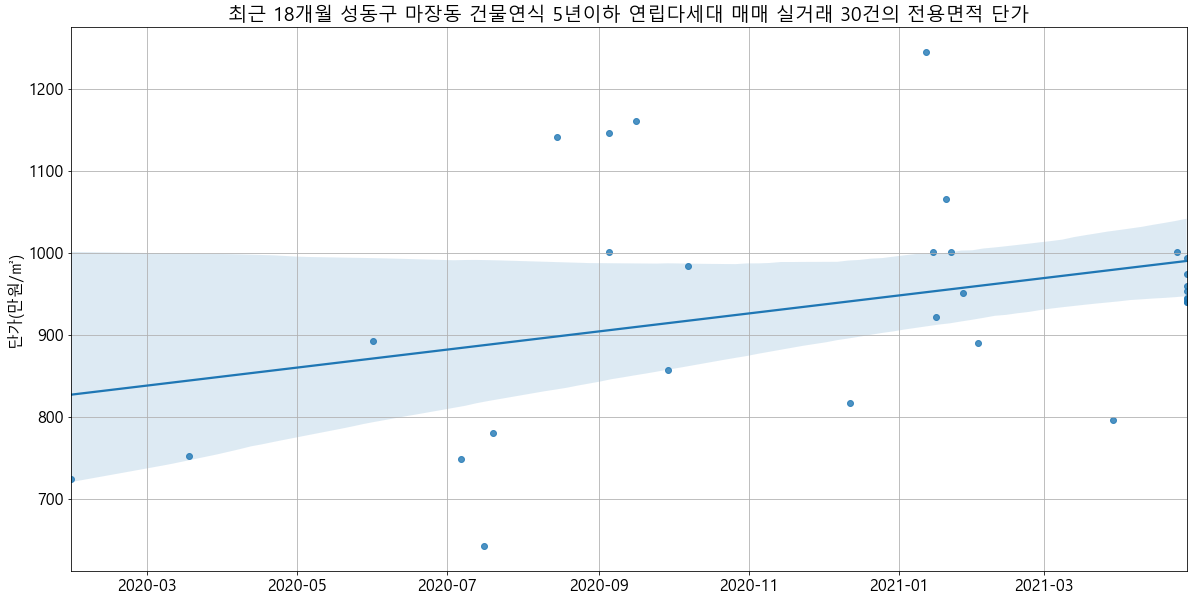

In [19]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, target_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df['계약날짜']), y=target_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/산포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [20]:
target_last_df = target_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last').reset_index(drop=True)

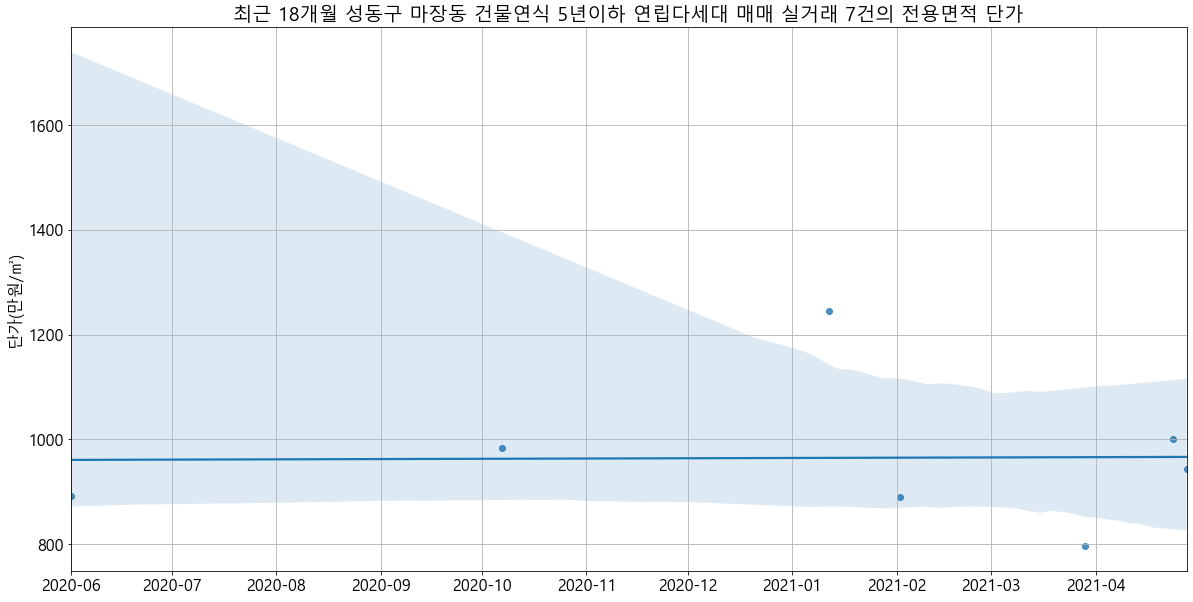

In [21]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, target_last_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_last_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_last_df['계약날짜']), y=target_last_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/마지막_산포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [22]:
target_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/마지막_실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

In [23]:
target_df2 = house_merge_df[
    (house_merge_df['구'] == target_gu)
    &(house_merge_df['동'] == target_dong)
    #&(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_merge_df['계약날짜기준_건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df2.shape)
target_df2.head()

(293, 22)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동
169964,서울특별시 성동구 마장동 465-21,청계천로12가길 51,(465-21),35.52,15.6,9000,3,2006.0,0.0,2006-12-26,253.378378,15.0,대,161.7,제3종일반주거지역,지정되지않음,주상기타,평지,가로장방,세로한면(가),성동구,마장동
169965,서울특별시 성동구 마장동 465-21,청계천로12가길 51,(465-21),18.90,8.3,7000,4,2006.0,0.0,2006-12-28,370.370370,15.0,대,161.7,제3종일반주거지역,지정되지않음,주상기타,평지,가로장방,세로한면(가),성동구,마장동
169966,서울특별시 성동구 마장동 465-21,청계천로12가길 51,(465-21),26.88,11.8,8400,4,2006.0,0.0,2006-12-29,312.500000,15.0,대,161.7,제3종일반주거지역,지정되지않음,주상기타,평지,가로장방,세로한면(가),성동구,마장동
169967,서울특별시 성동구 마장동 465-21,청계천로12가길 51,(465-21),35.52,15.6,11000,2,2006.0,0.0,2006-12-30,309.684685,15.0,대,161.7,제3종일반주거지역,지정되지않음,주상기타,평지,가로장방,세로한면(가),성동구,마장동
169968,서울특별시 성동구 마장동 465-21,청계천로12가길 51,(465-21),49.20,21.6,16000,3,2006.0,1.0,2007-01-01,325.203252,15.0,대,161.7,제3종일반주거지역,지정되지않음,주상기타,평지,가로장방,세로한면(가),성동구,마장동


In [24]:
target_df2 = get_index_applied_prices(target_df2)

<AxesSubplot:title={'center':'성동구 마장동 계약날짜기준 건물연식 5년이하 연립다세대 매매 실거래 293건의 전용면적 단가'}, xlabel='단가(만원/㎡)', ylabel='Count'>

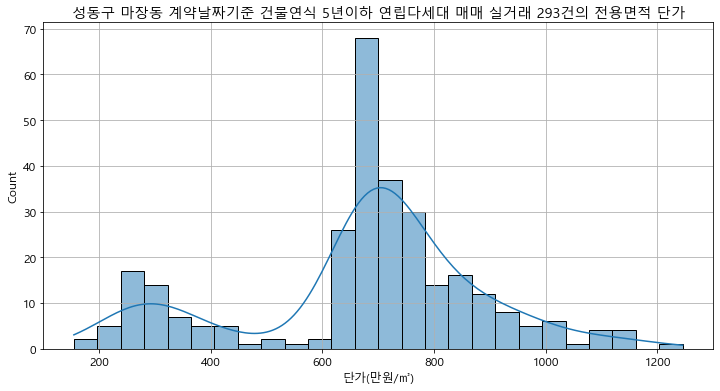

In [25]:
font = {'size': 12}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(12,6))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_gu, target_dong, target_building_age, target_house, target_df2.shape[0]))
plt.grid(True)
sns.histplot(target_df2['단가(만원/㎡)'], kde=True)

In [26]:
target_df3 = target_df2[['지번주소', '건물(단지)명', '건축년도', '전용면적(㎡)', '계약날짜', '단가(만원/㎡)', '평가날짜', '지수적용단가', '용도지역명1']]
target_df3 = target_df3.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df3.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지수적용_실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

In [27]:
concat_df = pd.concat([target_df2])

In [28]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '전용면적(㎡)', '계약날짜']).reset_index(drop=True)
concat_df = concat_df.drop_duplicates(['지번주소', '건축년도', '전용면적(㎡)'], keep='last').reset_index(drop=True)

In [29]:
concat_df['단가평균'] = concat_df[['지번주소', '건축년도', '단가(만원/㎡)']].groupby(['지번주소', '건축년도']).transform('mean')['단가(만원/㎡)']
concat_df['지수적용단가평균'] = concat_df[['지번주소', '건축년도', '지수적용단가']].groupby(['지번주소', '건축년도']).transform('mean')['지수적용단가']

In [30]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '평가날짜']).reset_index(drop=True)
print(concat_df.shape)
concat_df.head()

(114, 26)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜,단가평균,지수적용단가평균
0,서울특별시 성동구 마장동 399-57,마조로15길 17-5,(399-57),12.33,10.81,11151,2,2013.0,2.0,2015-03-18,904.379562,8.0,대,126.0,제2종일반주거지역,지정되지않음,다세대,평지,정방형,세로한면(가),성동구,마장동,1291.158049,2021-03-01,904.413878,1291.207041
1,서울특별시 성동구 마장동 399-57,마조로15길 17-5,(399-57),12.56,11.00,11359,4,2013.0,2.0,2015-03-18,904.378981,8.0,대,126.0,제2종일반주거지역,지정되지않음,다세대,평지,정방형,세로한면(가),성동구,마장동,1291.157219,2021-03-01,904.413878,1291.207041
2,서울특별시 성동구 마장동 399-57,마조로15길 17-5,(399-57),13.40,11.74,12119,3,2013.0,2.0,2015-03-18,904.402985,8.0,대,126.0,제2종일반주거지역,지정되지않음,다세대,평지,정방형,세로한면(가),성동구,마장동,1291.191489,2021-03-01,904.413878,1291.207041
3,서울특별시 성동구 마장동 399-57,마조로15길 17-5,(399-57),28.26,24.77,25561,4,2013.0,2.0,2015-03-18,904.493984,8.0,대,126.0,제2종일반주거지역,지정되지않음,다세대,평지,정방형,세로한면(가),성동구,마장동,1291.321406,2021-03-01,904.413878,1291.207041
4,서울특별시 성동구 마장동 399-59,마조로15길 15-2,시온아트빌,73.82,37.65,20000,4,2003.0,4.0,2007-01-22,270.929287,18.0,대,149.0,제2종일반주거지역,지정되지않음,단독,평지,사다리형,세로각지(가),성동구,마장동,503.731800,2021-03-01,249.446407,521.422417


In [31]:
concat_last_df = concat_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last')
print(concat_last_df.shape)
concat_last_df

(30, 26)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜,단가평균,지수적용단가평균
3,서울특별시 성동구 마장동 399-57,마조로15길 17-5,(399-57),28.26,24.77,25561,4,2013.0,2.0,2015-03-18,904.493984,8.0,대,126.0,제2종일반주거지역,지정되지않음,다세대,평지,정방형,세로한면(가),성동구,마장동,1291.321406,2021-03-01,904.413878,1291.207041
5,서울특별시 성동구 마장동 399-59,마조로15길 15-2,시온아트빌,78.96,40.28,18000,3,2003.0,3.0,2006-04-03,227.963526,18.0,대,149.0,제2종일반주거지역,지정되지않음,단독,평지,사다리형,세로각지(가),성동구,마장동,539.113033,2021-03-01,249.446407,521.422417
6,서울특별시 성동구 마장동 399-92,마조로1길 62,삼성아트빌,64.48,30.35,10000,1,2002.0,4.0,2006-11-13,155.086849,19.0,대,284.0,제3종일반주거지역,지정되지않음,연립,평지,세로장방,세로한면(가),성동구,마장동,301.709082,2021-03-01,155.086849,301.709082
7,서울특별시 성동구 마장동 399-93,마조로1길 60,오복아트빌,60.41,36.77,14500,4,2002.0,4.0,2006-12-06,240.026486,19.0,대,284.0,제3종일반주거지역,지정되지않음,다세대,평지,가로장방,세로한면(가),성동구,마장동,458.278525,2021-03-01,240.026486,458.278525
11,서울특별시 성동구 마장동 460-24,청계천로10가길 52,다임빌라,53.80,30.23,22000,3,2003.0,5.0,2008-04-16,408.921933,18.0,대,334.2,제2종일반주거지역,지정되지않음,주상기타,평지,가로장방,소로한면,성동구,마장동,542.897615,2021-03-01,402.316540,555.652412
13,서울특별시 성동구 마장동 460-3,청계천로10가길 64-12,서우빌라,45.09,35.13,19000,3,2008.0,1.0,2009-07-07,421.379463,13.0,대,106.1,제2종일반주거지역,지정되지않음,주상기타,평지,세로장방,세로한면(가),성동구,마장동,569.276869,2021-03-01,427.882233,578.062006
17,서울특별시 성동구 마장동 460-6,청계천로12가길 31,푸른솔빌라,53.82,39.90,25000,3,2003.0,5.0,2008-04-15,464.511334,18.0,대,64.5,제2종일반주거지역,지정되지않음,단독,평지,정방형,세로한면(가),성동구,마장동,616.699851,2021-03-01,411.569949,605.971657
18,서울특별시 성동구 마장동 464-11,청계천로10다길 50,뉴센트빌,29.98,18.48,19000,3,2013.0,3.0,2016-11-10,633.755837,8.0,대,166.0,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,세로한면(가),성동구,마장동,831.185705,2021-03-01,633.755837,831.185705
22,서울특별시 성동구 마장동 465-21,청계천로12가길 51,(465-21),49.20,21.60,17000,3,2006.0,2.0,2008-09-22,345.528455,15.0,대,161.7,제3종일반주거지역,지정되지않음,주상기타,평지,가로장방,세로한면(가),성동구,마장동,456.892949,2021-03-01,348.597454,563.663801
24,서울특별시 성동구 마장동 479-42,무학로14길 36-1,프라임빌,46.42,23.70,14500,3,2003.0,4.0,2007-09-19,312.365360,18.0,대,93.2,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,소로한면,성동구,마장동,503.929210,2021-03-01,325.022922,565.884890


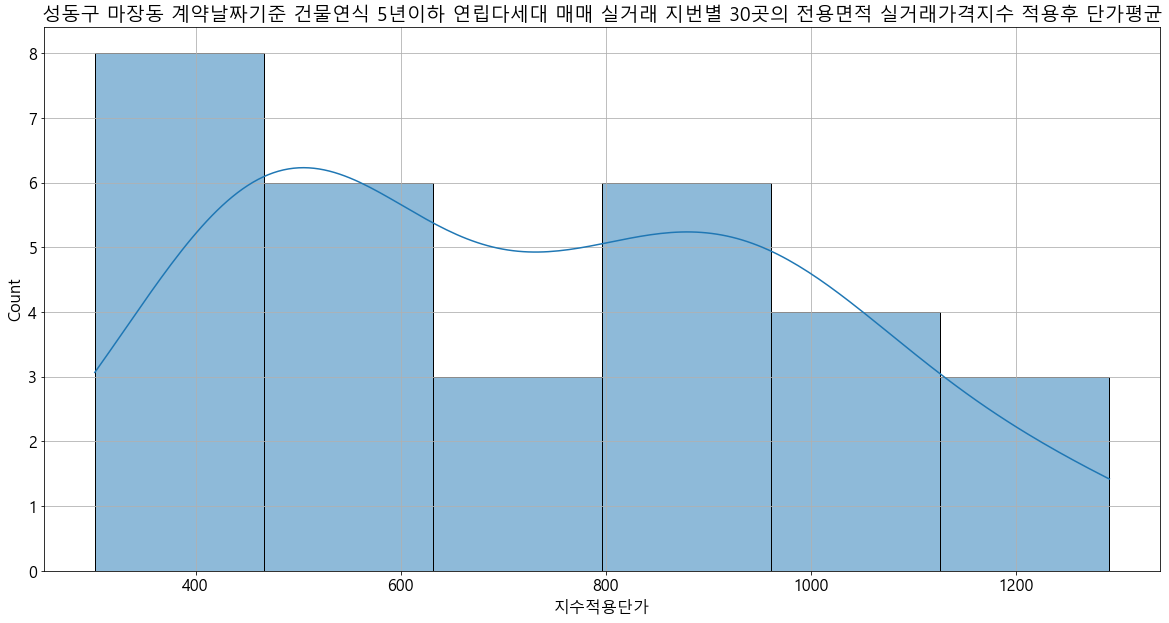

In [32]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 {} 매매 실거래 지번별 {}곳의 전용면적 실거래가격지수 적용후 단가평균'.format(target_gu, target_dong, target_building_age, target_house, concat_last_df.shape[0]))
plt.grid(True)
sns.histplot(concat_last_df['지수적용단가'], kde=True)
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지번별_분포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [33]:
concat_last_df = concat_last_df.sort_values(['지번주소']).reset_index(drop=True)

In [34]:
concat_last_df = concat_last_df[['지번주소', '건물(단지)명', '건축년도', '전용면적(㎡)', '계약날짜', '단가(만원/㎡)', '평가날짜', '지수적용단가', '용도지역명1']]
concat_last_df.rename(columns={'계약날짜':'마지막_계약날짜'}, inplace=True)
concat_last_df.head()

,지번주소,건물(단지)명,건축년도,전용면적(㎡),마지막_계약날짜,단가(만원/㎡),평가날짜,지수적용단가,용도지역명1
0,서울특별시 성동구 마장동 399-57,(399-57),2013.0,28.26,2015-03-18,904.493984,2021-03-01,1291.321406,제2종일반주거지역
1,서울특별시 성동구 마장동 399-59,시온아트빌,2003.0,78.96,2006-04-03,227.963526,2021-03-01,539.113033,제2종일반주거지역
2,서울특별시 성동구 마장동 399-92,삼성아트빌,2002.0,64.48,2006-11-13,155.086849,2021-03-01,301.709082,제3종일반주거지역
3,서울특별시 성동구 마장동 399-93,오복아트빌,2002.0,60.41,2006-12-06,240.026486,2021-03-01,458.278525,제3종일반주거지역
4,서울특별시 성동구 마장동 460-24,다임빌라,2003.0,53.80,2008-04-16,408.921933,2021-03-01,542.897615,제2종일반주거지역


In [35]:
concat_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지수적용_마지막_실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)